In [82]:
#coding:utf-8
import re
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import f1_score,auc
from sklearn.model_selection import train_test_split
# 假设抽取的样本同分布 则 test sets 中含有 19493 正样本
import matplotlib.pyplot as plt

In [83]:
def load_data(file_name):
    path_name = root_name + file_name + '.csv'
    return pd.read_csv(path_name)

In [84]:
def get_merge(all_data, dataset_name):
    for i in dataset_name:
        now_name = root_name + i + '.csv'
        now_fun = 'get_' + i
        now_data = pd.read_csv(now_name)
        now_fea = eval(now_fun)(now_data)
        print('Get features from {}.'.format(i))
        try:
            all_data = pd.merge(all_data,now_fea,on=['EID'],how='left')
        except:
            'MergeError!'
    all_data.fillna(-999)
    return all_data

In [85]:
def get_1entbase(entbase):
    return entbase.fillna(0)

In [86]:
# 提取数据中的数值
def get_number(s):
    try:
        return float(str(s).replace('万元',''))
    except:
        return 0.0

def get_2alter(alter):
    
    alter = alter.fillna(0)
    
    # 规范化ALTAF和ALTBE特征，构造两者的差作为新特征
    alter['ALTAF'] = np.log1p(alter['ALTAF'].map(get_number))
    alter['ALTBE'] = np.log1p(alter['ALTBE'].map(get_number))
    alter['ALTAF_ALTBE'] = alter['ALTAF'] - alter['ALTBE']
    
    # 构造年与月的特征
    alter['ALTDATE_YEAR'] = alter['ALTDATE'].map(lambda x:x.split('-')[0])# 分开表示年与月
    alter['ALTDATE_YEAR'] = alter['ALTDATE_YEAR'].astype(int)
    alter['ALTDATE_MONTH'] = alter['ALTDATE'].map(lambda x:x.split('-')[1])
    alter['ALTDATE_MONTH'] = alter['ALTDATE_MONTH'].astype(int)
    alter = alter.sort_values(['ALTDATE_YEAR','ALTDATE_MONTH'],ascending=True)

    # 变更的第一年
    alter_first_year = pd.DataFrame(alter[['EID','ALTDATE_YEAR']]).drop_duplicates(['EID'])
    # 变更的最后一年
    alter_last_year = pd.DataFrame(alter[['EID','ALTDATE_YEAR']]).sort_values(['ALTDATE_YEAR'],ascending=False).drop_duplicates(['EID'])
    
    # 标签化ALTERNO并计算均值与总值
    ALTERNO_to_index = list(alter['ALTERNO'].unique()) # ALTERNO的种类
    alter['ALTERNO'] = alter['ALTERNO'].map(ALTERNO_to_index.index) # ALTERNO里面有非数值，都换成index表示
    alter_ALTERNO = pd.get_dummies(alter['ALTERNO'], prefix='ALTERNO') # 哑编码ALTERNO的值
    alter_ALTERNO_merge = pd.concat([alter['EID'], alter_ALTERNO],axis=1)
    alter_ALTERNO_info_sum = alter_ALTERNO_merge.groupby(['EID'], as_index=False).sum()
    alter_ALTERNO_info_ration = alter_ALTERNO_merge.groupby(['EID']).mean().reset_index()

    alter_ALTERNO_info = pd.merge(alter_ALTERNO_info_sum,alter[['ALTAF_ALTBE','EID']],on=['EID']).drop_duplicates(['EID'])
    alter_ALTERNO_info = pd.merge(alter_ALTERNO_info,alter_last_year,on=['EID'])
    alter_ALTERNO_info = alter_ALTERNO_info.fillna(-1)
    
    return alter_ALTERNO_info

In [87]:
def get_3branch(branch):
    branch_copy = branch.copy()
    # print branch

    branch['B_ENDYEAR'] = branch['B_ENDYEAR'].fillna(branch['B_REYEAR'])
    branch['sub_life'] = branch['B_ENDYEAR'].fillna(branch['B_REYEAR']) - branch['B_REYEAR']
    # 筛选数据
    branch = branch[branch['sub_life']>=0]
    branch_count = branch.groupby(['EID'],as_index=False)['TYPECODE'].count()
    branch_count.rename(columns = {'TYPECODE':'branch_count'},inplace=True)
    branch = pd.merge(branch,branch_count,on=['EID'],how='left')
    branch['branch_count'] = np.log1p(branch['branch_count'])
    branch['branch_count'] = branch['branch_count'].astype(int)
    branch['sub_life'] = branch['sub_life'].replace({0.0:-1})

    home_prob = branch.groupby(by=['EID'])['IFHOME'].sum()/ branch.groupby(by=['EID'])['IFHOME'].count()
    home_prob = home_prob.reset_index()
    branch = pd.DataFrame(branch[['EID','sub_life']]).drop_duplicates('EID')
    branch = pd.merge(branch,home_prob,on=['EID'],how='left')
    return branch

In [88]:
def get_4invest(invest):
    invest['BTENDYEAR'] = invest['BTENDYEAR'].fillna(invest['BTYEAR'])
    invest['invest_life'] = invest['BTENDYEAR'] - invest['BTYEAR']
    invest_BTBL_sum = invest.groupby(['EID'],as_index=False)['BTBL'].sum()
    invest_BTBL_sum.rename(columns={'BTBL':'BTBL_SUM'},inplace=True)
    invest_BTBL_count = invest.groupby(['EID'],as_index=False)['BTBL'].count()
    invest_BTBL_sum.rename(columns={'BTBL':'BTBL_COUNT'},inplace=True)
    BTBL_INFO = pd.merge(invest_BTBL_sum,invest_BTBL_count,on=['EID'],how='left')
    BTBL_INFO['BTBL_RATIO'] = BTBL_INFO['BTBL_SUM'] / BTBL_INFO['BTBL']
    invest['invest_life'] = invest['invest_life'] > 0
    invest['invest_life'] = invest['invest_life'].astype(int)
    invest_life_ratio = invest.groupby(['EID'])['invest_life'].sum() / invest.groupby(['EID'])['invest_life'].count()
    invest_life_ratio = invest_life_ratio.reset_index()
    invest_life_ratio.rename(columns={'invest_life':'invest_life_ratio'},inplace=True)
    invest_last_year = invest.sort_values('BTYEAR',ascending=False).drop_duplicates('EID')[['EID','BTYEAR']]
    invest_first_year = invest.sort_values('BTYEAR').drop_duplicates('EID')[['EID','BTYEAR']]

    invest = pd.merge(invest[['EID']],BTBL_INFO,on=['EID'],how='left').drop_duplicates(['EID'])
    invest = pd.merge(invest,invest_life_ratio,on=['EID'],how='left')
    invest = pd.merge(invest,invest_last_year,on=['EID'],how='left')
    return invest

In [89]:
def get_5right(right):
    right_RIGHTTYPE = pd.get_dummies(right['RIGHTTYPE'],prefix='RIGHTTYPE')
    right_RIGHTTYPE_info = pd.concat([right['EID'],right_RIGHTTYPE],axis=1)
    right_RIGHTTYPE_info_sum = right_RIGHTTYPE_info.groupby(['EID'],as_index=False).sum().drop_duplicates(['EID'])
    right['ASKDATE_Y'] = right['ASKDATE'].map(lambda x:x.split('-')[0])
    right_last_year = right.sort_values('ASKDATE_Y',ascending=False).drop_duplicates('EID')[['EID','ASKDATE_Y']]
    right_last_year.rename(columns={'ASKDATE_Y':'right_last_year'},inplace=True)

    right_count = right.groupby(['EID'],as_index=False)['RIGHTTYPE'].count()

    right_count.rename(columns={'RIGHTTYPE':'right_count'},inplace=True)
    right = pd.merge(right[['EID']],right_RIGHTTYPE_info_sum,on=['EID'],how='left').drop_duplicates(['EID'])
    right = pd.merge(right,right_last_year,on=['EID'],how='left')
    right = pd.merge(right,right_count,on=['EID'],how='left')
    return right

In [90]:
def get_6project(project):
    project['DJDATE_Y'] = project['DJDATE'].map(lambda x:x.split('-')[0])
    project_DJDATE_Y = pd.get_dummies(project['DJDATE_Y'],prefix='DJDATE')
    project_DJDATE_Y_info = pd.concat([project['EID'],project_DJDATE_Y],axis=1)
    project_DJDATE_Y_info_sum = project_DJDATE_Y_info.groupby(['EID'],as_index=False).sum()
    project_DJDATE_Y_info_sum = project_DJDATE_Y_info_sum.drop_duplicates(['EID'])
    project_count = project.groupby(['EID'],as_index=False)['DJDATE'].count()
    project_count.rename(columns={'DJDATE':'project_count'},inplace=True)
    
    project_last_year = project.sort_values('DJDATE_Y',ascending=False).drop_duplicates('EID')[['EID','DJDATE_Y']]
    project = pd.merge(project[['EID']],project_last_year,on=['EID'],how='left').drop_duplicates(['EID'])
    project = pd.merge(project,project_DJDATE_Y_info_sum,on=['EID'],how='left')
    return project

In [91]:
def get_7lawsuit(lawsuit):
    lawsuit_LAWAMOUNT_sum = lawsuit.groupby(['EID'],as_index=False)['LAWAMOUNT'].sum()
    lawsuit_LAWAMOUNT_sum.rename(columns={'LAWAMOUNT':'lawsuit_LAWAMOUNT_sum'},inplace=True)
    lawsuit_LAWAMOUNT_sum['lawsuit_LAWAMOUNT_sum'] = np.log1p(lawsuit_LAWAMOUNT_sum['lawsuit_LAWAMOUNT_sum'])
    lawsuit_LAWAMOUNT_sum['lawsuit_LAWAMOUNT_sum'] = lawsuit_LAWAMOUNT_sum['lawsuit_LAWAMOUNT_sum'].astype(int)
    lawsuit_LAWAMOUNT_count = lawsuit.groupby(['EID'],as_index=False)['LAWAMOUNT'].count()
    lawsuit_LAWAMOUNT_count.rename(columns={'LAWAMOUNT':'lawsuit_LAWAMOUNT_count'},inplace=True)
    lawsuit['LAWDATE_Y'] = lawsuit['LAWDATE'].map(lambda x:x.split('年')[0])
    lawsuit_last_year = lawsuit.sort_values('LAWDATE_Y',ascending=False).drop_duplicates('EID')[['EID','LAWDATE_Y']]
    lawsuit = pd.merge(lawsuit_LAWAMOUNT_count,lawsuit_last_year,on=['EID'],how='left')
    return lawsuit

In [92]:
def get_8breakfaith(breakfaith):
    breakfaith['FBDATE_Y'] = breakfaith['FBDATE'].map(lambda x:x.split('/')[0])
    breakfaith_first_year = breakfaith.sort_values('FBDATE_Y').drop_duplicates('EID')[['EID','FBDATE_Y']]

    breakfaith['SXENDDATE'] = breakfaith['SXENDDATE'].fillna(0)
    breakfaith['is_breakfaith'] = breakfaith['SXENDDATE']!=0
    breakfaith['is_breakfaith'] = breakfaith['is_breakfaith'].astype(int)

    breakfaith_is_count = breakfaith.groupby(['EID'],as_index=False)['is_breakfaith'].count()
    breakfaith_is_sum = breakfaith.groupby(['EID'],as_index=False)['is_breakfaith'].sum()

    breakfaith_is_count.rename(columns={'is_breakfaith':'breakfaith_is_count'},inplace=True)
    breakfaith_is_sum.rename(columns={'is_breakfaith':'breakfaith_is_sum'},inplace=True)
    breakfaith_is_info = pd.merge(breakfaith_is_count,breakfaith_is_sum,on=['EID'],how='left')
    breakfaith_is_info['ratio'] = breakfaith_is_info['breakfaith_is_sum'] / breakfaith_is_info['breakfaith_is_count']
    return breakfaith_is_info

In [93]:
def get_9recruit(recruit):
    recruit['RECDATE_Y'] = recruit['RECDATE'].map(lambda x:x.split('-')[0])
    recruit_train_last_year = recruit.sort_values('RECDATE_Y',ascending=False).drop_duplicates('EID')[['EID','RECDATE_Y']]
    recruit_WZCODE = pd.get_dummies(recruit['WZCODE'],prefix='WZCODE')
    recruit_WZCODE_merge = pd.concat([recruit['EID'],recruit_WZCODE],axis=1)
    # 1
    recruit_WZCODE_info_sum = recruit_WZCODE_merge.groupby(['EID'],as_index=False).sum().drop_duplicates(['EID'])
    # 2
    recruit['RECRNUM'] = recruit['RECRNUM'].fillna(0)
    recruit_RECRNUM_count = recruit.groupby(['EID'],as_index=False)['RECRNUM'].count()
    recruit_RECRNUM_count.rename(columns={'RECRNUM':'recruit_RECRNUM_count'},inplace=True)
    # 3
    recruit_RECRNUM_sum = recruit.groupby(['EID'],as_index=False)['RECRNUM'].sum()
    recruit_RECRNUM_sum.rename(columns={'RECRNUM':'recruit_RECRNUM_sum'},inplace=True)
    recruit_RECRNUM_sum['recruit_RECRNUM_sum'] = recruit_RECRNUM_sum['recruit_RECRNUM_sum']
    # 4
    recruit_RECRNUM_info = pd.merge(recruit[['EID']],recruit_RECRNUM_sum,on=['EID']).drop_duplicates(['EID'])
    recruit_RECRNUM_info = pd.merge(recruit_RECRNUM_info,recruit_RECRNUM_count,on=['EID'])
    recruit_RECRNUM_info['recurt_info_ration'] = recruit_RECRNUM_info['recruit_RECRNUM_sum'] / recruit_RECRNUM_info['recruit_RECRNUM_count']
    recruit_RECRNUM_info = pd.merge(recruit_WZCODE_info_sum,recruit_RECRNUM_info,on=['EID'],how='left')
    return recruit_RECRNUM_info

Load finished.
Start generating training features...
Get features from 1entbase.
Get features from 2alter.
Get features from 3branch.
Get features from 4invest.
Get features from 5right.
Get features from 6project.
Get features from 7lawsuit.
Get features from 8breakfaith.
Get features from 9recruit.
Start generating test features...
Get features from 1entbase.
Get features from 2alter.
Get features from 3branch.
Get features from 4invest.
Get features from 5right.
Get features from 6project.
Get features from 7lawsuit.
Get features from 8breakfaith.
Get features from 9recruit.
54
Index([u'TARGET', u'RGYEAR', u'HY', u'ZCZB', u'ETYPE', u'MPNUM', u'INUM',
       u'FINZB', u'FSTINUM', u'TZINUM', u'ALTERNO_0', u'ALTERNO_1',
       u'ALTERNO_2', u'ALTERNO_3', u'ALTERNO_4', u'ALTERNO_5', u'ALTERNO_6',
       u'ALTERNO_7', u'ALTERNO_8', u'ALTERNO_9', u'ALTERNO_10', u'ALTERNO_11',
       u'ALTAF_ALTBE', u'ALTDATE_YEAR', u'sub_life', u'IFHOME', u'BTBL_SUM',
       u'BTBL', u'BTBL_RATIO', u'inve

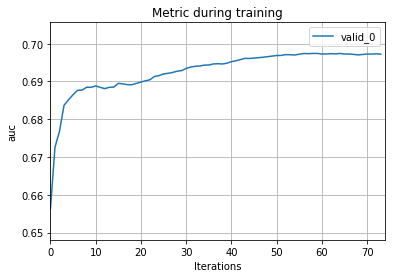

Plot feature importances...


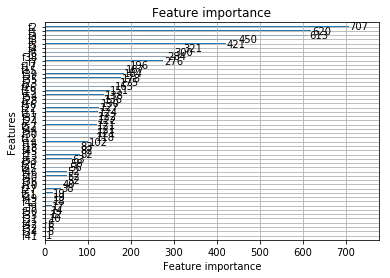

Start predicting...
('predict pos tation', 19739)
102124


In [94]:
# Load raw datasets and generate new ones
root_name = '/Users/schwein/PycharmProjects/Try_games/20171115_FirmRisk/try_model/datasets/'
dataset_name = ['1entbase','2alter','3branch','4invest','5right','6project','7lawsuit','8breakfaith','9recruit']

train = load_data('train')
test = load_data('evaluation_public')
print('Load finished.')
print('Start generating training features...')
train = get_merge(train, dataset_name)
print('Start generating test features...')
test = get_merge(test, dataset_name)

del train['EID']
test_index = test.pop('EID')

# Run the model
import lightgbm as lgb
# 抽样选择数据
tmp1 = train[train.TARGET==1]
tmp0 = train[train.TARGET==0]
x_valid_1 = tmp1.sample(frac=0.3, random_state=70, axis=0)
x_train_1 = tmp1.drop(x_valid_1.index.tolist())
x_valid_2 = tmp0.sample(frac=0.1, random_state=70, axis=0)
x_train_2 = tmp0.drop(x_valid_2.index.tolist())
X_train = pd.concat([x_train_1,x_train_2],axis=0)

y_train = X_train.pop('TARGET')
X_test = pd.concat([x_valid_1,x_valid_2],axis=0)
y_test = X_test.pop('TARGET')

feature_len = X_train.shape[1]
print(feature_len)
print train.columns

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 128,
    'learning_rate': 0.08,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0
}
evals_result = {}
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 1000,
                valid_sets=lgb_eval,
                feature_name=['f' + str(i + 1) for i in range(feature_len)],
                early_stopping_rounds= 15 ,
                evals_result=evals_result)

print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

print('Plot feature importances...')
lgb.plot_importance(gbm,max_num_features=feature_len)
plt.show()

print('Start predicting...')

y_pred = gbm.predict(test.values, num_iteration=gbm.best_iteration)
y_pred = np.round(y_pred,8)
result = pd.DataFrame({'PROB':list(y_pred),
                       })
result['FORTARGET'] = result['PROB'] > 0.22
result['PROB'] = result['PROB'].astype('str')
result['FORTARGET'] = result['FORTARGET'].astype('int')
result = pd.concat([test_index,result],axis=1)

print('predict pos tation',sum(result['FORTARGET']))

result = pd.DataFrame(result).drop_duplicates(['EID'])
save_path = root_name + 'evaluation_public_new.csv'
result[['EID','FORTARGET','PROB']].to_csv(save_path,index=None)

print(len(result.EID.unique()))